In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import jax.numpy as jnp

import h5py

import corner

import gw_pop_numpyro

import seaborn as sns

TO DO: Rerun with new priors on at and bt and more PE samples per event.
worried that current priors having too much of an effect especially for long time delays, prior on formation rate isn't flexible enough to include inferred merger rate evolution under phenomenological power law model.
Data could also be saying that it does not like the model/ maximum redshift at z = 20.
Especially in combination with long time delays! long time delay model sucks. argue this by reporting max likelihoods. 

In [2]:
from gw_pop_numpyro import config, setup_injections_PE, numpyro_sample, popmodels, postproc, plot_helper

Text(0.5, 1.0, 'example formation rate curves within prior')

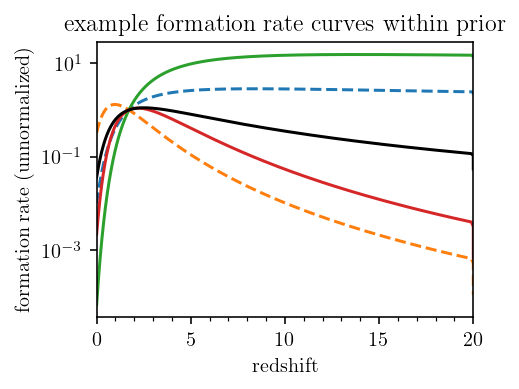

In [3]:
from gw_pop_numpyro import distributions as dist

tL_plot = np.linspace(0, 13.7, 1000)*1e3
z_plot = config.cosmo_dict["z_at_lookback_time"](tL_plot)
y = dist.rate_lookbacktime(tL_plot, 0.3, 5e-4, config.cosmo_dict)
y2 = dist.rate_lookbacktime(tL_plot, 3, 5e-4, config.cosmo_dict)


plt.plot(z_plot, y, ls = '--')
plt.plot(z_plot, y2, ls = '--')

y = dist.rate_lookbacktime(tL_plot, 0.3, 1e-3, config.cosmo_dict)
y2 = dist.rate_lookbacktime(tL_plot, 3, 1e-3, config.cosmo_dict)

plt.plot(z_plot, y)
plt.plot(z_plot, y2)


plt.plot(z_plot, dist.rate_lookbacktime(tL_plot, 1.3, 5e-4, config.cosmo_dict), c = 'k')

plt.yscale('log')
plt.xlim(0,20)

plt.xlabel('redshift')
plt.ylabel('formation rate (unnormalized)')
plt.title('example formation rate curves within prior')

In [4]:
tL_forms = np.linspace(1, config.cosmo_dict["age_of_universe"], 1000)


def formation_rate_at_tL_samps(hypersamps, tL_forms):
    
    zmerge_grid = jnp.linspace(0, config.zmerge_max, 1000)
    
    hyper_keys = pop_model._param_names

    nhyper = len(hypersamps[hyper_keys[0]])
    
    Rfs = np.zeros((nhyper, len(tL_forms)))
    
    for i in range(nhyper):
        
        pop = pop_model(**{key: hypersamps[key][i] for key in hyper_keys})
    
        log_Rf = jnp.log(hypersamps["rate_N"][i]) + pop.log_Vct_dist(tL_forms) - pop.logznorm(zmerge_grid, PEsamples["tau_grid"], PEsamples["ptau_grid"])
                
        Rfs[i, :] = jnp.exp(log_Rf)
    
    return Rfs

### Population model

In [5]:
pop_model = popmodels.bandpass_plpeak_mass_formation_time_Gaussian_chieff_dist

pop_model._param_names

['mmin',
 'mmax',
 'alpha1',
 'fpeak',
 'mupeak',
 'sigpeak',
 'n1',
 'n2',
 'beta',
 'at',
 'bt',
 'mu',
 'sig']

### define and sample from prior

In [6]:
prior = numpyro_sample.get_prior_function(pop_model, config.DEFAULT_HYPERPRIOR) 

prior_sampler, prior_samples = numpyro_sample.sample_from_posterior(prior, num_warmup = 2000, num_samples = 2000, progress_bar = True)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 441.31it/s, 7 steps of size 6.29e-01. acc. prob=0.86]


In [7]:
config.DEFAULT_HYPERPRIOR

{'mmin': [3, 12],
 'mmax': [30, 80],
 'alpha1': [-6, -0.5],
 'fpeak': [0.0001, 0.3],
 'mupeak': [25, 50],
 'sigpeak': [2, 8],
 'n1': [2, 20],
 'n2': [2, 20],
 'beta': [-2, 6],
 'a': [0, 6],
 'b': [0, 6],
 'zp': [0.5, 6],
 'zmax': [10, 20.0],
 'mu': [-0.5, 0.5],
 'sig': [0.03, 0.5],
 'at': [0.3, 2.6],
 'bt': [0.0001, 0.001]}

In [8]:
#add in prior on normalization
prior_samples["rate_N"] = np.exp(7 + 6 * np.random.random(2000))

### PE samples and injections

In [9]:
PE_settings = {
        'dir_O3a' : "/Users/mayafishbach/Desktop/O3samples/O3a/",
        'dir_O3a_p1' : "/Users/mayafishbach/Desktop/O3samples/O3a-p1/",
        'dir_O3b': "/Users/mayafishbach/Desktop/O3samples/O3b/",
        'dir_O2' :  "/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/",
        'exclude' : ['GW170817', 'GW190425', 'GW190814', 'GW190426', 'GW190909', 'GW190514_065416', 'GW190917', 'GW200105', 'GW200115', 'GW200220_061928', "GW191113_071753", "GW191126_115259", "GW191204_110529", "GW191219_163120", "GW200208_222617", "GW200210_092254", "GW200220_061928", "GW200220_124850", "GW200306_093714", "GW200308_173609", "GW200322_091133"],
        'spin' :  'eff',
        'tL' : False,
        'Vc_t' : False,
        'nsamples' : 2000
        }


PEsamples, events = setup_injections_PE.preprocess_PE(**PE_settings)
inj, Ndraw,  Tobs_years = setup_injections_PE.preprocess_injections(**config.default_injection_settings)

In [10]:
len(events)

69

In [11]:
seed = 1148

### Fit for formation rate assuming delay time model

In [12]:
from delay_time_helper import ptau, draw_delay_times, add_formation_tL

tmaxmax = config.cosmo_dict["lookback_time"](20)

def fit_formation_rate(tmin = 10, alpha = -1, num_warmup = 2000, num_samples = 2000):
    add_formation_tL(samples = PEsamples, tmin = tmin, alpha = alpha, truncate_tmax = False, seed = seed)
    add_formation_tL(samples = inj, tmin = tmin, alpha = alpha, truncate_tmax = False, seed = seed)
    
    #just to ensure that none of the functions break, set all formation times larger than first star formation tmaxmax to tmaxmax.
    #The formation rate is defined to be identically zero at tmaxmax (and higher) anyway,
    #so this is just a convenience.
    #we also have to do it in a roundabout way because jax.numpy doesn't let you change array elements like this.
    inj_inter = np.array(inj["formation_lookback_time"])
    inj_inter[inj_inter >= tmaxmax] = tmaxmax
    inj["formation_lookback_time"] = inj_inter
    plt.hist(inj["formation_lookback_time"]/1e3)
    plt.xlabel("injections: formation lookback time")
    plt.ylabel("counts")
    plt.show()
    
    PE_inter = np.array(PEsamples["formation_lookback_time"])
    PE_inter[PE_inter >= tmaxmax] = tmaxmax
    PEsamples["formation_lookback_time"] = PE_inter
    plt.hist(PEsamples["formation_lookback_time"].flatten()/1e3)
    plt.xlabel("PE samples: formation lookback time")
    plt.ylabel("counts")
    plt.show()
    
    #define posterior
    posterior_func = numpyro_sample.get_posterior_function(pop_model, prior, PEsamples, inj, Ndraw)

    #sample from posterior
    sampler, samples = numpyro_sample.sample_from_posterior(posterior_func, num_warmup = num_warmup, num_samples = num_samples, progress_bar = True)
    
    sampler.print_summary()
    
    #plot posterior on formation rate evolution params
    sns.kdeplot(samples['at'], samples['bt']*1e3, levels = [0.05, 0.1, 0.5])
    plt.scatter(1.34, 0.43, marker = '*')
    plt.xlabel('at')
    plt.ylabel('bt')
    plt.title('formation rate hyperparams')
    plt.show()
    
    #save hyperposterior samples
    #with h5py.File(f"formation_time_hypersamples_tmin{tmin}_al{-alpha}_fix.h5", 'w') as out:
        #for key in samples.keys():
        #    out.create_dataset(name = key, data = samples[key])
        
    #compute rate in post-processing
    hypersamps = dict()
    for key in samples.keys():
        hypersamps[key] = samples[key]
        
    hypersamps = postproc.save_lognorm(hypersamps, pop_model, lognorm_kwargs = dict(tau_grid = PEsamples["tau_grid"], ptau_grid = PEsamples["ptau_grid"]))
    hypersamps = postproc.save_rate_N(hypersamps, inj, Ndraw, Tobs_years, len(events), pop_model)
    
    #plot hyperposterior on rate_N
    plt.hist(np.log(hypersamps["rate_N"]))
    plt.xlabel('log_rate_N')
    plt.ylabel('counts')
    plt.show()

    #compute formation rate on a grid
    Rfs = formation_rate_at_tL_samps(hypersamps, tL_forms)
    
    #compute prior formation rate draws on grid of tL_forms, this depends on assumed delay time distribution for normalization
    Rfs_prior = formation_rate_at_tL_samps(prior_samples, tL_forms)
    
    
    #save hyperposterior and rate (posterior and prior) samples
    with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'w') as out:
        for key in samples.keys():
            out.create_dataset(name = key, data = samples[key])
        out.create_dataset(name = 'tL_forms', data = tL_forms)
        out.create_dataset(name = 'Rf_posterior', data = Rfs)
        out.create_dataset(name = 'Rf_prior', data = Rfs_prior)
        
    #plot prior and posterior on formation rate
    fig, ax = plt.subplots(constrained_layout=True)

    xs = config.cosmo_dict["z_at_lookback_time"](tL_forms)

    plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior, color = sns.color_palette()[1])
    
    plot_helper.plot_bands(ax, xs, 1e9 * Rfs)

    ax.set_yscale('log')

    ax.set_xlim(0, 20)

    ax.set_xlabel('Redshift')

    ax.set_ylabel('Formation rate')
    
    plt.show()

### "Default" delay time model 
(power law with minimum 10 Myr and slope -1) 

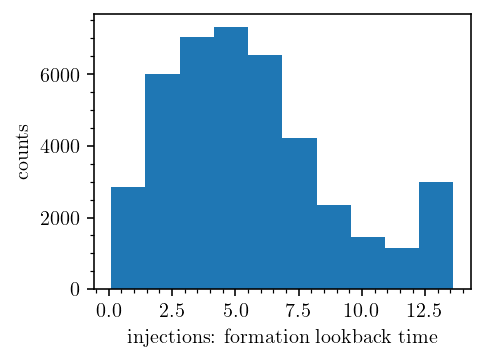

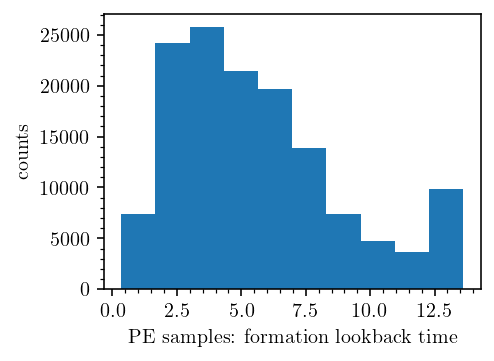

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [16:36<00:00,  4.01it/s, 15 steps of size 2.20e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -3.16      0.43     -3.18     -3.87     -2.48    582.78      1.00
        at      1.46      0.62      1.44      0.60      2.58   1383.48      1.00
      beta      1.72      1.11      1.60     -0.07      3.40   1398.91      1.00
        bt      0.00      0.00      0.00      0.00      0.00   1169.60      1.00
     fpeak      0.00      0.01      0.00      0.00      0.01    704.08      1.00
      mmax     64.58     13.15     68.54     42.39     79.99    638.42      1.00
      mmin      7.84      0.97      7.94      6.41      9.42   1064.07      1.00
        mu      0.05      0.02      0.06      0.02      0.09   1923.74      1.00
    mupeak     34.45      1.58     34.52     31.98     36.91    848.38      1.00
        n1     14.23      3.97     14.73      8.54     19.99   3754.80      1.00
        n2      8.30      5.35      6.77      2.00     16.72   1225.63      1.00
       sig      0.10      0

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


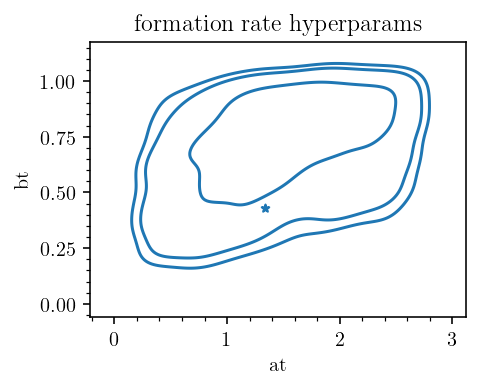

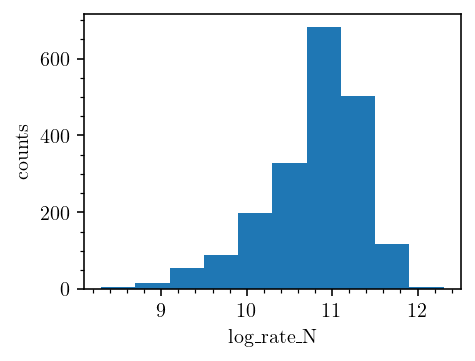

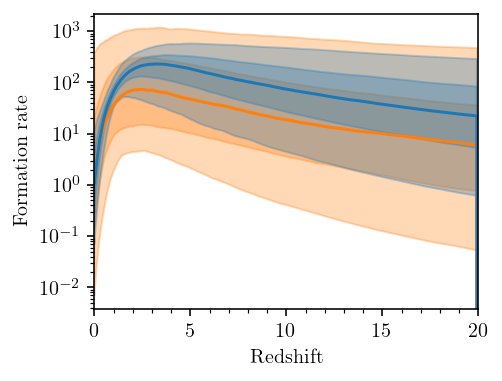

In [13]:
fit_formation_rate(tmin = 10, alpha = -1)

### Shallow delay time model (representative of SMT-only)
(power law with minimum 10 Myr and slope -0.35) 

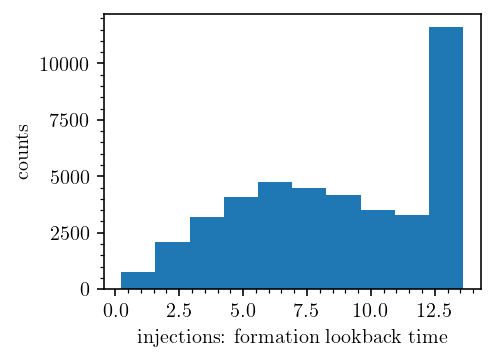

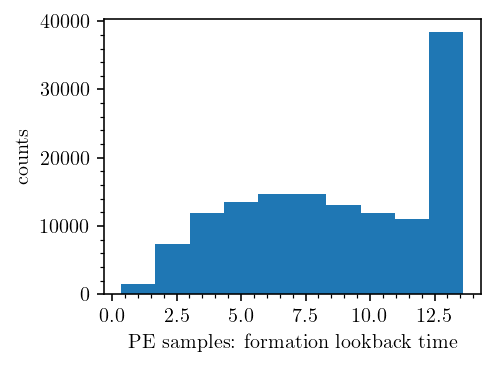

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [16:10<00:00,  4.12it/s, 15 steps of size 2.30e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -2.96      0.42     -2.97     -3.69     -2.34    677.79      1.00
        at      1.68      0.61      1.76      0.78      2.60   1622.07      1.00
      beta      2.05      1.14      1.90      0.10      3.69   1008.13      1.00
        bt      0.00      0.00      0.00      0.00      0.00   1468.50      1.00
     fpeak      0.01      0.01      0.00      0.00      0.01    623.21      1.00
      mmax     65.77     12.70     69.77     44.93     79.99    674.54      1.00
      mmin      7.83      1.00      7.93      6.42      9.52    981.22      1.00
        mu      0.06      0.02      0.06      0.03      0.09   1924.83      1.00
    mupeak     35.12      1.60     35.20     32.83     37.75    686.71      1.00
        n1     14.19      3.95     14.63      8.30     19.93   3121.21      1.00
        n2      8.61      5.46      7.43      2.01     17.08   1370.66      1.00
       sig      0.08      0

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


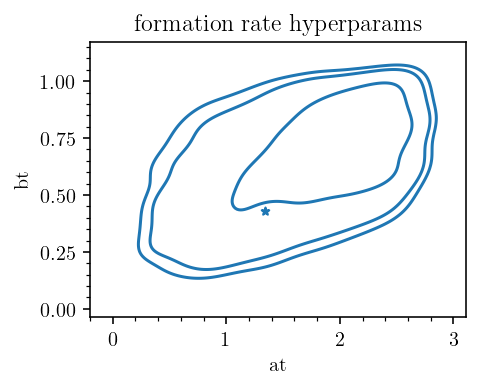

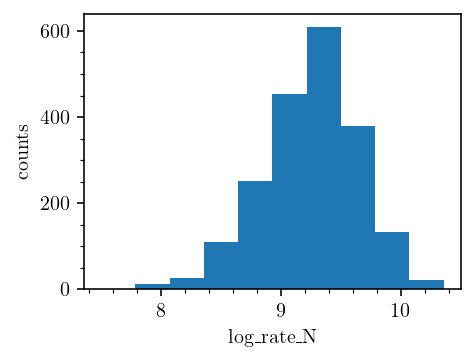

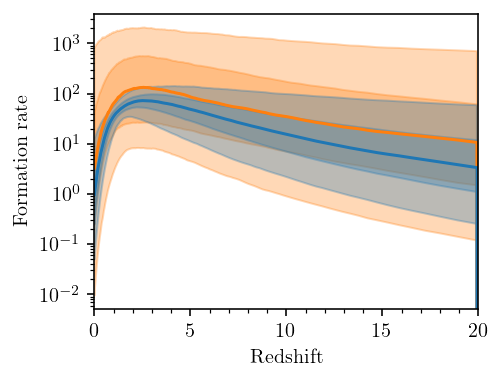

In [16]:
fit_formation_rate(tmin = 10, alpha = -0.35)

### Medium delay time model
(power law with minimum 10 Myr and slope -0.7) 

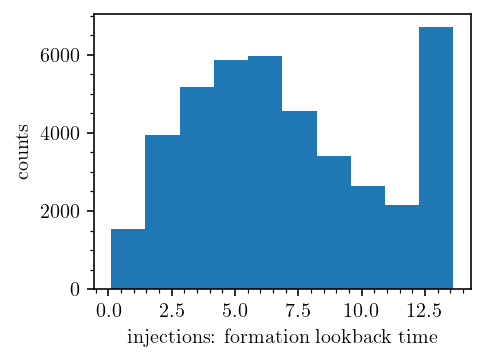

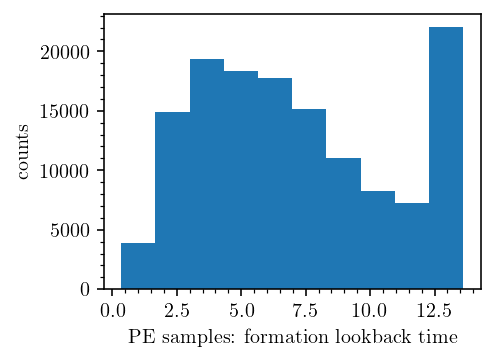

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [18:32<00:00,  3.59it/s, 31 steps of size 1.66e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -3.05      0.41     -3.07     -3.75     -2.41    700.42      1.00
        at      1.29      0.69      1.21      0.30      2.35   1374.44      1.00
      beta      2.03      1.07      1.89      0.24      3.64   1275.28      1.00
        bt      0.00      0.00      0.00      0.00      0.00   1212.26      1.00
     fpeak      0.00      0.01      0.00      0.00      0.01    701.02      1.00
      mmax     65.60     12.59     69.23     45.02     79.99    683.52      1.00
      mmin      7.72      1.02      7.80      6.16      9.38    934.52      1.00
        mu      0.05      0.02      0.05      0.02      0.09   1712.37      1.00
    mupeak     34.71      1.38     34.74     32.60     37.01   1322.33      1.00
        n1     14.33      3.91     15.04      8.67     19.98   2219.43      1.00
        n2      8.67      5.49      7.54      2.00     17.52   1227.32      1.00
       sig      0.10      0

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


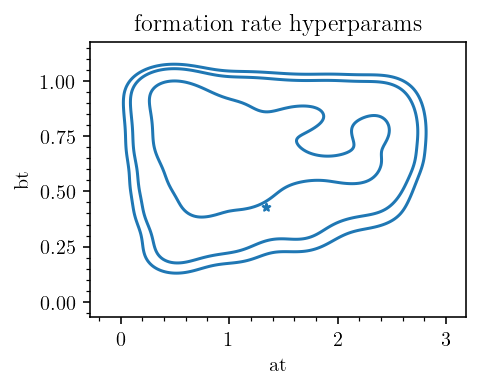

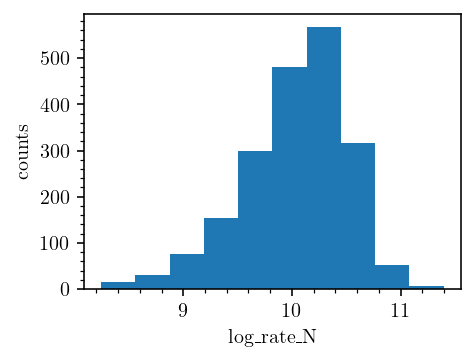

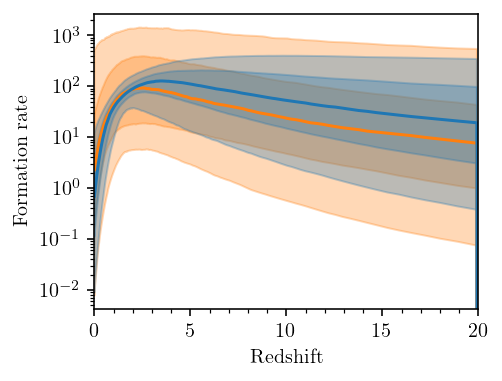

In [15]:
fit_formation_rate(tmin = 10, alpha = -0.7)

### sanity checks

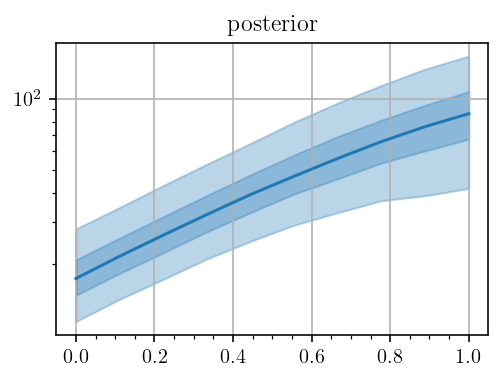

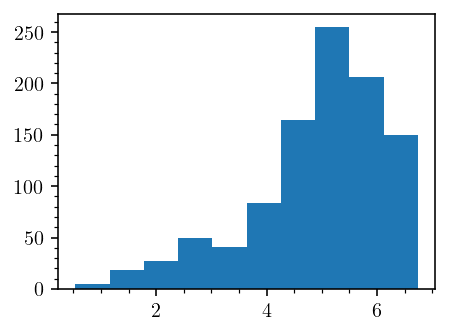

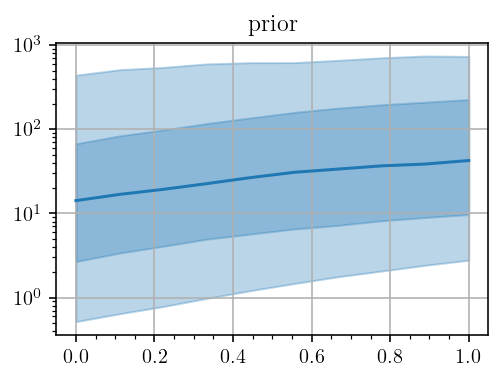

(array([100.,  82.,  68.,  59.,  61.,  83., 146., 151., 129., 121.]),
 array([0.2269405 , 0.87739516, 1.52784982, 2.17830448, 2.82875914,
        3.4792138 , 4.12966846, 4.78012313, 5.43057779, 6.08103245,
        6.73148711]),
 <BarContainer object of 10 artists>)

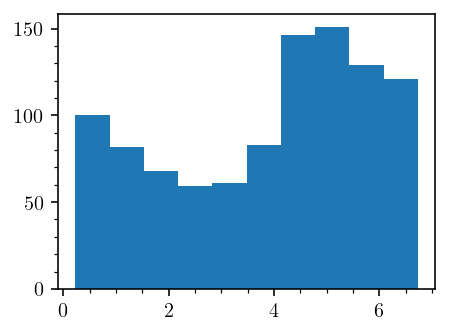

In [14]:
tmaxmax = config.cosmo_dict["lookback_time"](20)
import delay_time_helper
from gw_pop_numpyro import distributions



age_m_grid = config.cosmo_dict["age_of_universe"] - config.cosmo_dict["lookback_time"](np.linspace(0,1,10))

tmin = 10
alpha = -1

tau_grid = np.logspace(np.log10(tmin), np.log10(tmaxmax), 1000)
ptau_grid =  delay_time_helper.ptau(tau_grid, tmin, alpha = alpha, tmax = tmaxmax)

with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs = np.array(inp["Rf_posterior"])
    Rfs_prior = np.array(inp["Rf_prior"])
    tL_forms = np.array(inp["tL_forms"])
    
merger_rates = np.zeros((1000,10))
    
for i in range(1000):

    def formation_rate_at_age_func(T):
        return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs[i,:])

    merger_rates[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func)

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, np.linspace(0,1,10), 1e9 * merger_rates)

plt.title('posterior')
plt.yscale('log')
plt.grid()
plt.show()

plt.hist(merger_rates[:,-1]/merger_rates[:,0])

for i in range(1000):

    def formation_rate_at_age_func(T):
        return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs_prior[i,:])

    merger_rates[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func)

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, np.linspace(0,1,10), 1e9 * merger_rates)

plt.title('prior')
plt.yscale('log')
plt.grid()
plt.show()

plt.hist(merger_rates[:,-1]/merger_rates[:,0])

7.0552945


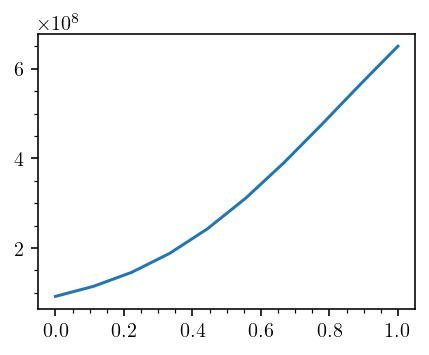

In [79]:
merger_rate = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, lambda T: distributions.rate_age(T, 3, 1e-3))

print(merger_rate[-1]/merger_rate[0])

plt.plot(np.linspace(0,1,10), merger_rate)

In [83]:
config.cosmo_dict['lookback_time'](10), config.cosmo_dict['lookback_time'](20)

(DeviceArray(13325.121, dtype=float32), DeviceArray(13619.099, dtype=float32))

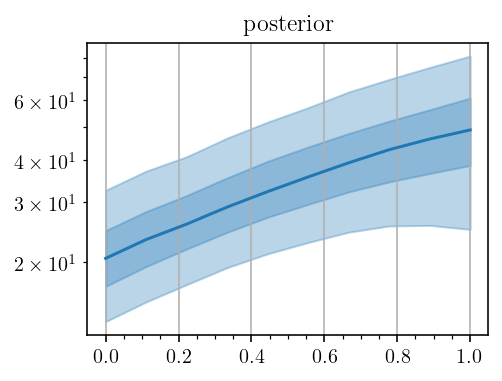

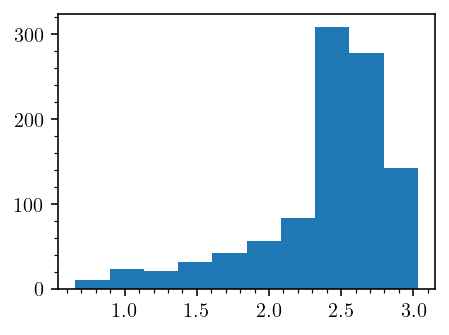

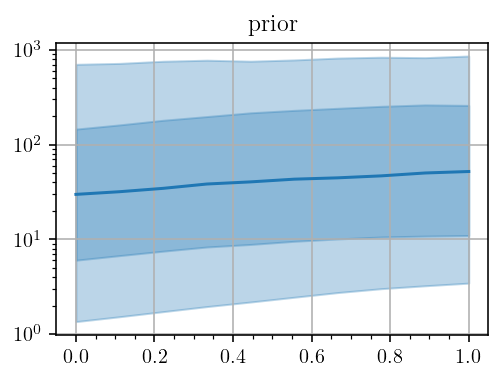

(array([ 59.,  58.,  59.,  64.,  54.,  61.,  62., 141., 249., 193.]),
 array([0.18500818, 0.47052514, 0.7560421 , 1.04155906, 1.32707603,
        1.61259299, 1.89810995, 2.18362691, 2.46914388, 2.75466084,
        3.0401778 ]),
 <BarContainer object of 10 artists>)

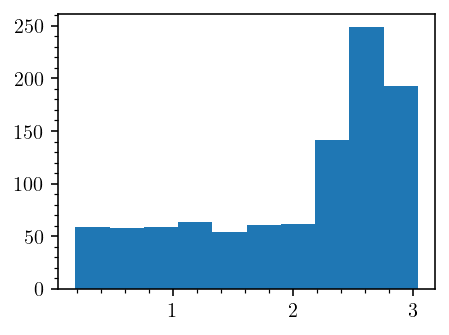

In [17]:
tmaxmax = config.cosmo_dict["lookback_time"](20)
import delay_time_helper
from gw_pop_numpyro import distributions



age_m_grid = config.cosmo_dict["age_of_universe"] - config.cosmo_dict["lookback_time"](np.linspace(0,1,10))

tmin = 10
alpha = -0.7

tau_grid = np.logspace(np.log10(tmin), np.log10(tmaxmax), 1000)
ptau_grid =  delay_time_helper.ptau(tau_grid, tmin, alpha = alpha, tmax = tmaxmax)

with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs = np.array(inp["Rf_posterior"])
    Rfs_prior = np.array(inp["Rf_prior"])
    tL_forms = np.array(inp["tL_forms"])
    
merger_rates = np.zeros((1000,10))
    
for i in range(1000):

    def formation_rate_at_age_func(T):
        return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs[i,:])

    merger_rates[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func)

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, np.linspace(0,1,10), 1e9 * merger_rates)

plt.title('posterior')
plt.yscale('log')
plt.grid()
plt.show()

plt.hist(merger_rates[:,-1]/merger_rates[:,0])

for i in range(1000):

    def formation_rate_at_age_func(T):
        return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs_prior[i,:])

    merger_rates[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func)

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, np.linspace(0,1,10), 1e9 * merger_rates)

plt.title('prior')
plt.yscale('log')
plt.grid()
plt.show()

plt.hist(merger_rates[:,-1]/merger_rates[:,0])

2.5896335


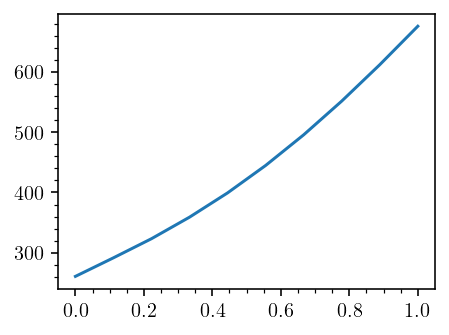

In [18]:
merger_rate = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, lambda T: distributions.rate_age(T, 1.3, 1e-3))

print(merger_rate[-1]/merger_rate[0])

plt.plot(np.linspace(0,1,10), merger_rate)

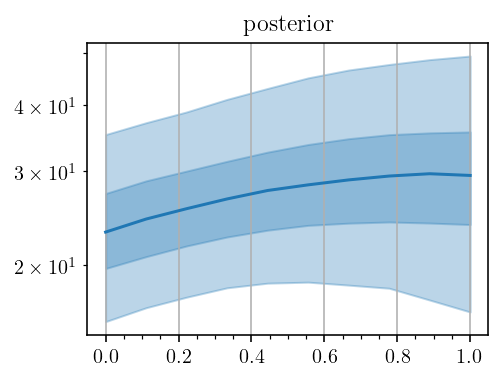

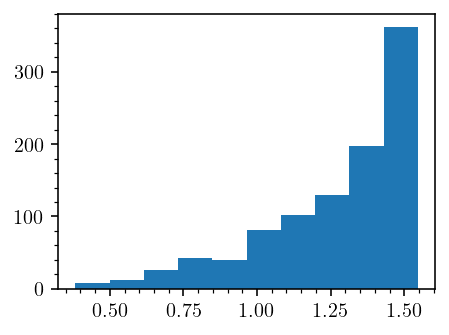

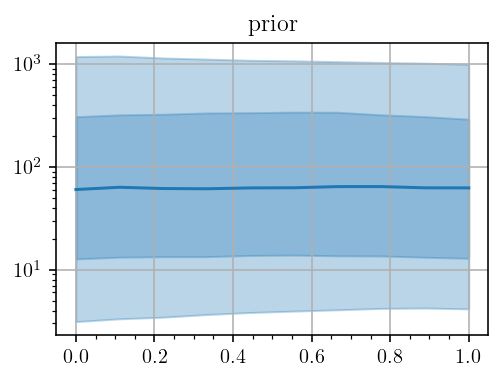

(array([ 41.,  52.,  49.,  53.,  72.,  64.,  71.,  85., 115., 398.]),
 array([0.13492277, 0.27594123, 0.41695968, 0.55797813, 0.69899659,
        0.84001504, 0.98103349, 1.12205195, 1.2630704 , 1.40408885,
        1.54510731]),
 <BarContainer object of 10 artists>)

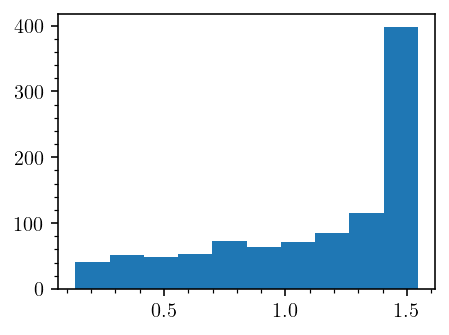

In [19]:
tmaxmax = config.cosmo_dict["lookback_time"](20)
import delay_time_helper
from gw_pop_numpyro import distributions



age_m_grid = config.cosmo_dict["age_of_universe"] - config.cosmo_dict["lookback_time"](np.linspace(0,1,10))

tmin = 10
alpha = -0.35

tmax_max = tmaxmax

tau_grid = np.logspace(np.log10(tmin), np.log10(tmax_max), 1000)
ptau_grid =  delay_time_helper.ptau(tau_grid, tmin, alpha = alpha, tmax = tmax_max)

with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs = np.array(inp["Rf_posterior"])
    Rfs_prior = np.array(inp["Rf_prior"])
    tL_forms = np.array(inp["tL_forms"])
    
merger_rates = np.zeros((1000,10))
    
for i in range(1000):

    def formation_rate_at_age_func(T):
        return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs[i,:])

    merger_rates[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func)

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, np.linspace(0,1,10), 1e9 * merger_rates)

plt.title('posterior')
plt.yscale('log')
plt.grid()
plt.show()

plt.hist(merger_rates[:,-1]/merger_rates[:,0])

for i in range(1000):

    def formation_rate_at_age_func(T):
        return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs_prior[i,:])

    merger_rates[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func)

fig, ax = plt.subplots(constrained_layout=True)


plot_helper.plot_bands(ax, np.linspace(0,1,10), 1e9 * merger_rates)

plt.title('prior')
plt.yscale('log')
plt.grid()
plt.show()

plt.hist(merger_rates[:,-1]/merger_rates[:,0])

1.6181561


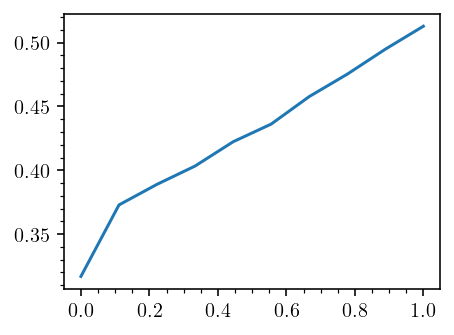

In [20]:
merger_rate = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, lambda T: distributions.rate_age(T, 0.3, 1e-3))

print(merger_rate[-1]/merger_rate[0])

plt.plot(np.linspace(0,1,10), merger_rate)

Inferred merger rate doesn't rise steeply enough, but that's because it gets cut off by the prior!